In [2]:
from collections import deque, namedtuple
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import gymnasium as gym

KeyboardInterrupt: 

In [3]:
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "terminated"])

class QNetwork:
    def __init__(self, num_inputs, num_outputs, learning_rate):
        self._model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(num_inputs,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(num_outputs)
        ])
        self._model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.MeanSquaredError()
        )
        self._loss_fn = tf.keras.losses.MeanSquaredError()

    @tf.function
    def train(self, states, target_q_values):
        with tf.GradientTape() as tape:
            q_values = self._model(states, training=True)
            loss = self._loss_fn(target_q_values, q_values)
        gradients = tape.gradient(loss, self._model.trainable_variables)
        self._model.optimizer.apply_gradients(zip(gradients, self._model.trainable_variables))

    # Predict method, again with manual @tf.function for efficiency.
    @tf.function
    def predict(self, states):
        return self._model(states)


    # The following method copies weights from a given QNetwork to the current one.
    @tf.function
    def copy_weights_from(self, other):
        for var, other_var in zip(self._model.variables, other._model.variables):
            var.assign(other_var)

In [4]:

class DeepQLearningAgent:
    def __init__(
        self,
        num_inputs,
        num_outputs,
        learning_rate=5e-3,
        batch_size=64,
        num_batches=1,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        gamma=0.99,
        target_model_update_interval=100
    ):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.learning_rate = learning_rate

        self.q_network = QNetwork(num_inputs, num_outputs, learning_rate)
        self.target_network = QNetwork(num_inputs, num_outputs, learning_rate)
        self.target_network.copy_weights_from(self.q_network)

        self.replay_buffer = deque(maxlen=100000)

        self.batch_size = batch_size
        self.num_batches = num_batches

        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma

        self.target_model_update_interval = target_model_update_interval
        self.update_counter = 0
    def save(self, path="models/dqn_lander"):
        os.makedirs(path, exist_ok=True)
        self.q_network._model.save(os.path.join(path, "q_network"))
        self.target_network._model.save(os.path.join(path, "target_network"))
        np.save(os.path.join(path, "meta.npy"), {
            'epsilon': self.epsilon,
            'update_counter': self.update_counter
        }, allow_pickle=True)

    # Save the state, action, reward, next_state and terminated to buffer
    def memorize(self, state, action, reward, next_state, terminated):
        self.replay_buffer.append(Transition(np.array(state), action, reward, np.array(next_state), terminated))


    # Returns action - in an epsilon-greedy manner when training, otherwise the best predicted
    def action(self, state, train=False):
        if train and np.random.uniform() < self.epsilon:
            return np.random.randint(self.num_outputs)
        else:
            return np.argmax(self.q_network.predict(np.array(state).reshape(1, -1))[0])


    # Training using the replay buffer
    def train(self):
        # We cannot train when there is not enough data in the replay buffer
        if len(self.replay_buffer) < self.batch_size:
            return

        # Update the target network, when required
        if self.update_counter >= self.target_model_update_interval:
            self.update_counter = 0
            self.target_network.copy_weights_from(self.q_network)

        self.update_counter += 1

        for _ in range(self.num_batches):
            # Sample a minibatch from the buffer
            batch_indices = np.random.choice(len(self.replay_buffer), self.batch_size, replace=False)

            states = np.array([self.replay_buffer[i].state for i in batch_indices])
            next_states = np.array([self.replay_buffer[i].next_state for i in batch_indices])
            actions = np.array([self.replay_buffer[i].action for i in batch_indices])
            rewards = np.array([self.replay_buffer[i].reward for i in batch_indices])
            not_terminations = np.array([not self.replay_buffer[i].terminated for i in batch_indices])

            states = states.reshape((-1, self.num_inputs))
            next_states = next_states.reshape((-1, self.num_inputs))

            # Predict the Q-values
            predicted = np.array(self.q_network.predict(states))
            next_predicted = np.array(self.target_network.predict(next_states))

            # Compute the target values (using the Bellman equations and target network)
            # (When truncated, we did not reach a final state and the episode would continue to go on -
            # if not for the timestep limit meant only as a way of keeping the episodes reasonably long,
            # so we do treat the state the episode was truncated in as any other state, unlike the state
            # the episode was terminated in, when we do not add the estimate of the future return to the
            # current reward when computing the target Q-value.)
            target_q_values = predicted
            target_q_values[range(target_q_values.shape[0]), actions] = \
                rewards + not_terminations * self.gamma * np.max(next_predicted, axis=-1)

            self.q_network.train(states, target_q_values)

        # Lower the epsilon for the epsilon-greedy strategy
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon * self.epsilon_decay

Lunar Lander training setup

Episode 0, Avg reward (last 50): -84.73, Epsilon: 0.946
Episode 50, Avg reward (last 50): -242.37, Epsilon: 0.010
Episode 100, Avg reward (last 50): -325.14, Epsilon: 0.010
Episode 150, Avg reward (last 50): -247.03, Epsilon: 0.010
Episode 200, Avg reward (last 50): -238.84, Epsilon: 0.010
Episode 250, Avg reward (last 50): -203.13, Epsilon: 0.010
Episode 300, Avg reward (last 50): -225.67, Epsilon: 0.010
Episode 350, Avg reward (last 50): -186.76, Epsilon: 0.010
Episode 400, Avg reward (last 50): -245.93, Epsilon: 0.010
Episode 450, Avg reward (last 50): -199.44, Epsilon: 0.010
Episode 500, Avg reward (last 50): -118.90, Epsilon: 0.010
Episode 550, Avg reward (last 50): -294.95, Epsilon: 0.010
Episode 600, Avg reward (last 50): -320.47, Epsilon: 0.010
Episode 650, Avg reward (last 50): -449.52, Epsilon: 0.010
Episode 700, Avg reward (last 50): -222.71, Epsilon: 0.010
Episode 750, Avg reward (last 50): -116.15, Epsilon: 0.010
Episode 800, Avg reward (last 50): -112.73, Epsilon: 0.010
E

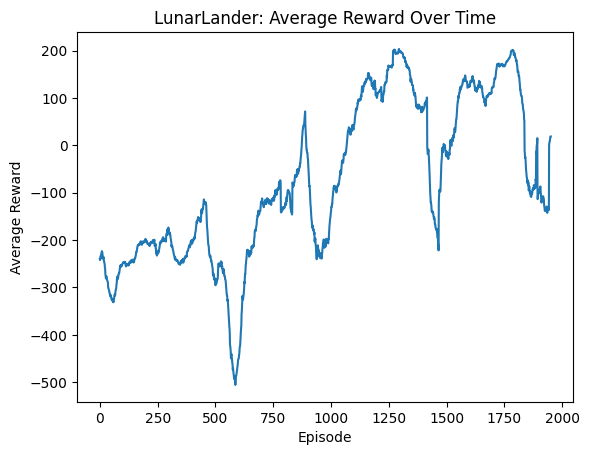

In [5]:
# LunarLander training setup
env = gym.make('LunarLander-v3',)
num_inputs = env.observation_space.shape[0]
num_outputs = env.action_space.n

agent = DeepQLearningAgent(
    num_inputs=num_inputs,
    num_outputs=num_outputs,
    learning_rate=1e-3,
    batch_size=64,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01,
    gamma=0.99,
    target_model_update_interval=200
)

num_episodes = 2000
reward_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.action(state, train=True)
        next_state, reward, done, truncated, _ = env.step(action)
        agent.memorize(state, action, reward, next_state, done or truncated)
        agent.train()
        state = next_state
        total_reward += reward

    reward_history.append(total_reward)

    if episode % 50 == 0:
        avg_reward = np.mean(reward_history[-50:])
        print(f"Episode {episode}, Avg reward (last 50): {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

plt.plot(np.convolve(reward_history, np.ones(50)/50, mode='valid'))
plt.title("LunarLander: Average Reward Over Time")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.show()


Run this cell to show 5 runs of how it lands the LunarLander and prints its score. Even after quite long training the lander sometimes still just flies away and not managing to land. But from my testing in most cases it lands close to the marks.

In [1]:
agent.epsilon = 0.0

env = gym.make("LunarLander-v3", render_mode="human")

for episode in range(5):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.action(state, train=False)
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward
    print(f"Episode {episode + 1} reward: {total_reward:.2f}")

NameError: name 'agent' is not defined